In [1]:
# --> Install necessary packages
!pip3 install --quiet "pytorch-lightning" "thop" "wandb"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requi

NOTE: Oversampling path shall be disabled until the final experiment execution begins, as this is to reduce the time and storage that are needed for this

In [2]:
import os
import time
import random
import wandb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

%matplotlib inline
from types import SimpleNamespace
from IPython.display import display
from torchmetrics.functional import accuracy
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0
from torch.utils.data import random_split, DataLoader, Dataset
from tensorboard.backend.event_processing import event_accumulator
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning import LightningDataModule
from kaggle_secrets import UserSecretsClient
from thop import profile

pl.seed_everything(42)
NUM_WORKERS = os.cpu_count()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yoga-sugitha22 (yoga-sugitha22-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
## Should be adjusted for the end-to-end experiment
DATASET_NORMAL_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_normal/train"
# "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_normal-20251113T104849Z-1-001/cnn_dataset_normal/train"
DATASET_UNDERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_undersampling/train"
# "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_undersampling-20251113T104849Z-1-001/cnn_dataset_undersampling/train"
DATASET_OVERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_oversampling/train"

### WOrktable

In [5]:
full_dataset = datasets.ImageFolder(root=DATASET_UNDERSAMPLING_PATH)
paths = [sample[0] for sample in full_dataset.imgs]  # file paths
labels = [sample[1] for sample in full_dataset.imgs]  # class indices
class_names = full_dataset.classes
class_names

['0_tidak_bingung', '1_bingung']

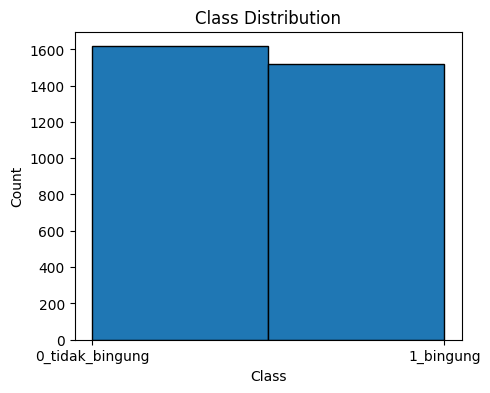

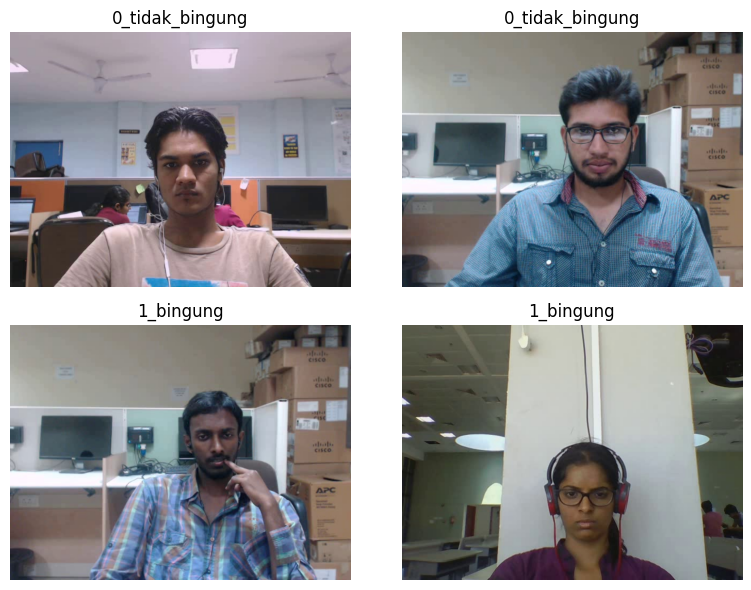

In [6]:
# --- Plot class distribution ---
plt.figure(figsize=(5, 4))
plt.hist(labels, bins=len(class_names), edgecolor='black')
plt.xticks(np.arange(len(class_names)), class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# --- Visualize 2 samples per class ---
samples_per_class = 2
fig, axes = plt.subplots(nrows=2, ncols=samples_per_class, figsize=(8, 6))

for i, class_idx in enumerate(range(len(class_names))):
    # Get indices of samples from this class
    class_indices = [idx for idx, label in enumerate(labels) if label == class_idx]
    # Randomly select 2 images
    chosen_indices = random.sample(class_indices, samples_per_class)
    for j, idx in enumerate(chosen_indices):
        img_path = paths[idx]
        img = plt.imread(img_path)
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_names[class_idx])
        
plt.tight_layout()
plt.show()

In [7]:
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [8]:
class DataModule(LightningDataModule):
    def __init__(self, data_dir, preproc_type ="Normal", batch_size=128, test_size=0.2, val_size=0.25, random_state=42):
        super().__init__()
        self.data_dir = data_dir
        self.preproc_type = preproc_type
        self.batch_size = batch_size
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def setup(self, stage:str=None):
        # Step 1: Load full
        full_dataset = datasets.ImageFolder(root=DATASET_NORMAL_PATH)
        paths = [sample[0] for sample in full_dataset.imgs]  # file paths
        labels = [sample[1] for sample in full_dataset.imgs]  # class indices

        # Step 2: Stratified split
        # First split: separate test set (e.g., 20%)
        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            paths, labels, test_size=0.2, stratify=labels, random_state=42
        )
        
        # Second split: split remaining into train and val (e.g., 75% of remaining → 60% train, 20% val)
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
        )

        # Define transforms
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            transforms.ToTensor(),
        ])
        transform_eval = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        # Define the stage; fit --> train and val, test --> test
        if stage=="fit":
            self.train_dataset = ImagePathDataset(train_paths, train_labels, transform=transform_train)
            self.val_dataset = ImagePathDataset(val_paths, val_labels, transform=transform_eval)
            
        if stage=="test":
            self.test_dataset = ImagePathDataset(test_paths, test_labels, transform=transform_eval)
            

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, pin_memory=True, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, pin_memory=True, num_workers=NUM_WORKERS)

In [9]:
dm_under = DataModule(data_dir=DATASET_UNDERSAMPLING_PATH, preproc_type="Undersampling")
dm_normal = DataModule(data_dir=DATASET_NORMAL_PATH, preproc_type="Normal")
dm_over = DataModule(data_dir=DATASET_OVERSAMPLING_PATH, preproc_type="Oversampling")

## Model Initialization

#### Model dissection for later ablation studies

In [10]:
# model = efficientnet_b0(weights="IMAGENET1K_V1")
# print(model) # --- too long

In [11]:
# for name, module in model.features.named_children():
#     print(name, module)

In [12]:
# for name, module in model.features.named_children():
#     print(name, module)

In [13]:
class EEffModelTF(nn.Module):
    def __init__(self, num_classes=2, c_m=512, act_fn=nn.SiLU, dropout=0.5):
        super().__init__()
        self.base = efficientnet_b0(weights='DEFAULT')
        self.base.classifier = nn.Identity() # --> acts as a placeholder that effectively "removes" a layer's functionality while maintaining the structural integrity of the nn.Module hierarchy
        self.fc = nn.Sequential(
            nn.Linear(1280, c_m),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_m,1),
        )

    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

    def get_model_metrics(self, input_size=(1, 3, 224, 224)):
        """Calculate model metrics: params, FLOPs, inference time"""
        device = next(self.parameters()).device
        dummy_input = torch.randn(input_size).to(device)
        
        # Count parameters
        num_params = sum(p.numel() for p in self.parameters())
        
        # Calculate FLOPs
        flops, _ = profile(self, inputs=(dummy_input,), verbose=False)
        
        # Measure inference time
        self.eval()
        with torch.no_grad():
            start_time = time.time()
            for _ in range(100):  # Average over 100 inferences
                _ = self(dummy_input)
            end_time = time.time()
        avg_inference_time = (end_time - start_time) / 100
        
        return {
            'num_params': num_params,
            'flops': flops,
            'avg_inference_time': avg_inference_time
        }

In [14]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

In [15]:
class EffNetModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model(model_name, model_hparams)
        self.loss_module = nn.BCEWithLogitsLoss()

    def forward(self, imgs): # classifier use this
        return self.model(imgs)

    def configure_optimizers(self):
        if self.hparams.optimizer_name == "Adam":
            optimizer = optim.Adam(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams) 
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'
        
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1, patience=3, verbose=True
            ),
            "monitor": "val_loss",  # crucial for Lightning
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        
        acc = ((torch.sigmoid(preds) > 0.5).float().squeeze() == labels.squeeze()).float().mean()
        
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        
        acc = ((torch.sigmoid(preds) > 0.5).float().squeeze() == labels.squeeze()).float().mean()
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(imgs)
        acc = ((torch.sigmoid(preds) > 0.5).float().squeeze() == labels.squeeze()).float().mean()
        
        self.log("test_acc", acc, prog_bar=True)
        return {"test_acc": acc}

In [16]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU, "silu": nn.SiLU}

In [17]:
def train_single_experiment(model_name, dataset_name, optimizer_name, model_hparams, 
                           optimizer_hparams, data_module, 
                           seed=42, max_epochs=100):
    """Train a single experiment with a specific seed using LightningDataModule"""
    pl.seed_everything(seed)
    
    # Create experiment name
    experiment_name = f"{model_name}_{dataset_name}_{optimizer_name}_seed{seed}"
    
    # Initialize WandB logger
    wandb_logger = pl.loggers.WandbLogger(
        name=experiment_name,
        project="ACRIG-DAiSEE-confusion_detection",
        config={
            "model_name": model_name,
            "dataset_name": dataset_name,
            "optimizer_name": optimizer_name,
            "model_hparams": model_hparams,
            "optimizer_hparams": optimizer_hparams,
            "seed": seed,
            "max_epochs": max_epochs
        }
    )
    
    # Create trainer
    trainer = pl.Trainer(
        default_root_dir=f"checkpoints/{experiment_name}",
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        logger=wandb_logger,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, 
                mode="max", 
                monitor="val_acc",
                dirpath=f"checkpoints/{experiment_name}",
                filename="best-checkpoint"
            ),
            LearningRateMonitor("epoch"),
            EarlyStopping(monitor="val_loss", mode="min", patience=5)
        ],
        log_every_n_steps=10,
        enable_checkpointing=True
    )
    
    # Create and train model
    model = EffNetModule(
        model_name=model_name,
        model_hparams=model_hparams,
        optimizer_name=optimizer_name,
        optimizer_hparams=optimizer_hparams
    )
    
    # Train using the data module
    trainer.fit(model, datamodule=data_module)
    
    # Test using the data module
    test_result = trainer.test(model, datamodule=data_module, verbose=False)
    
    # Calculate model metrics
    model_metrics = model.model.get_model_metrics()
    
    # Log model metrics to WandB
    wandb_logger.experiment.log({
        'num_params': model_metrics['num_params'],
        'flops': model_metrics['flops'],
        'avg_inference_time': model_metrics['avg_inference_time'],
        'final_test_acc': test_result[0]['test_acc']
    })
    
    # Close WandB run
    wandb_logger.experiment.finish()
    
    return {
        'test_acc': test_result[0]['test_acc'],
        'model_metrics': model_metrics
    }

In [18]:
model_dict["efficientnet_b0"] = EEffModelTF

In [19]:
def run_experiment_with_seeds(model_name, dataset_name, optimizer_name, model_hparams, 
                             optimizer_hparams, data_module, 
                             seeds=[42, 123, 456], max_epochs=100):
    """Run experiment across multiple seeds and compute mean ± std using LightningDataModule"""
    
    results = []
    model_metrics_list = []
    
    print(f"Running {model_name} on {dataset_name} with {optimizer_name} across {len(seeds)} seeds...")
    
    for seed in seeds:
        print(f"  Seed {seed}...")
        result = train_single_experiment(
            model_name, dataset_name, optimizer_name, model_hparams,
            optimizer_hparams, data_module,
            seed=seed, max_epochs=max_epochs
        )
        results.append(result['test_acc'])
        model_metrics_list.append(result['model_metrics'])
    
    # Calculate mean and std across seeds
    results_array = np.array(results)
    mean_acc = np.mean(results_array)
    std_acc = np.std(results_array)
    
    # Use metrics from first seed (they should be the same for the same model)
    avg_metrics = {
        'num_params': model_metrics_list[0]['num_params'],
        'flops': model_metrics_list[0]['flops'],
        'avg_inference_time': np.mean([m['avg_inference_time'] for m in model_metrics_list])
    }
    
    print(f"  Result: {mean_acc:.4f} ± {std_acc:.4f}")
    
    return {
        'mean_test_acc': mean_acc,
        'std_test_acc': std_acc,
        'all_results': results,
        'model_metrics': avg_metrics
    }

In [20]:
def run_comprehensive_experiments(data_modules_dict, seeds=[42, 123, 456]):
    """
    Run comprehensive experiments across multiple datasets, models, optimizers, and seeds.
    
    Args:
        data_modules_dict: Dict with keys like 'normal', 'over', 'under' containing data modules
        seeds: List of seeds to run experiments across
    """
    
    results_summary = []
    
    # Define experiment configurations
    models_to_test = ['efficientnet_b0']
    datasets_to_test = ['normal', 'over', 'under']  # keys from data_modules_dict
    optimizers_to_test = ['Adam', 'SGD']
    
    model_hparams = {
        'c_m': 512,
        'act_fn': nn.ReLU,
        'dropout': 0.5
    }
    
    optimizer_configs = {
        'Adam': {'lr': 1e-3, 'weight_decay': 1e-4},
        'SGD': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 1e-4}
    }
    
    for model_name in models_to_test:
        for dataset_name in datasets_to_test:
            for optimizer_name in optimizers_to_test:
                
                print(f"\n{'='*60}")
                print(f"Running experiment: {model_name} on {dataset_name} with {optimizer_name}")
                print(f"{'='*60}")
                
                # Get the appropriate data module
                data_module = data_modules_dict[dataset_name]
                
                # Setup if not already done
                if not hasattr(data_module, 'train_dataset'):
                    data_module.setup()
                
                # Run experiment across multiple seeds
                exp_result = run_experiment_with_seeds(
                    model_name=model_name,
                    dataset_name=dataset_name,
                    optimizer_name=optimizer_name,
                    model_hparams=model_hparams,
                    optimizer_hparams=optimizer_configs[optimizer_name],
                    data_module=data_module,
                    seeds=seeds,
                    max_epochs=100
                )
                
                summary = {
                    'model': model_name,
                    'dataset': dataset_name,
                    'optimizer': optimizer_name,
                    'mean_test_acc': exp_result['mean_test_acc'],
                    'std_test_acc': exp_result['std_test_acc'],
                    'num_params': exp_result['model_metrics']['num_params'],
                    'flops': exp_result['model_metrics']['flops'],
                    'avg_inference_time': exp_result['model_metrics']['avg_inference_time'],
                    'all_seed_results': exp_result['all_results']
                }
                
                results_summary.append(summary)
                print(f"Final result: {exp_result['mean_test_acc']:.4f} ± {exp_result['std_test_acc']:.4f}")
    
    return results_summary

## Call on the run

In [21]:
# effnet_model, effnet_results = train_single_experiment(
#     model_name="efficientnet_b0", 
#     dataset_name="Daisee_undersampling", 
#     optimizer_name="Adam", 
#     model_hparams={"num_classes":2, "act_fn":nn.ReLU, "c_m":256}, 
#     optimizer_hparams={"lr":1e-4}, 
#     data_module=dm_under, 
#     seed=42, 
#     max_epochs=50
# )

In [22]:
data_modules = {
    'normal': dm_normal,  # No need to call setup()
    'over': dm_over, 
    'under': dm_under
}

results = run_comprehensive_experiments(data_modules)


Running experiment: efficientnet_b0 on normal with Adam


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running efficientnet_b0 on normal with Adam across 3 seeds...
  Seed 42...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s] 
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_152328-fb8xf5sb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_normal_Adam_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/fb8xf5sb
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▅▆▅█
wandb:          train_loss █▆▅▅▄▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▆▇▆██▁▆
wandb:            val_loss ▂▁▆▁█▇▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03051
wandb:               epoch 7
wandb:      final_test_acc 0.70855
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70855
wandb:           train_acc 0.75017
wandb:          train_loss 0.52438
wandb: trainer/global_step 161
wandb:             val_acc 0.70722
wandb:            val_loss 0.57171
wandb: 
wandb: 🚀 View run effi

  Seed 123...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_152547-tabkvkyq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_normal_Adam_seed123
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/tabkvkyq
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▅▅▆▇█
wandb:          train_loss █▆▅▅▄▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▁█▇▆▅▅▁
wandb:            val_loss ▃▁▄▂▃█▄
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03006
wandb:               epoch 7
wandb:      final_test_acc 0.72194
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.72194
wandb:           train_acc 0.74948
wandb:          train_loss 0.51159
wandb: trainer/global_step 161
wandb:             val_acc 0.69485
wandb:            val_loss 0.59198
wandb: 
wandb: 🚀 View run effi

  Seed 456...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_152804-lcukg9im
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_normal_Adam_seed456
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/lcukg9im
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▅▇█
wandb:          train_loss █▆▄▃▃▂▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▁▅█▅▅▆▆
wandb:            val_loss ▆▁▃▅█▅▁
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.02956
wandb:               epoch 7
wandb:      final_test_acc 0.70855
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70855
wandb:           train_acc 0.74605
wandb:          train_loss 0.54228
wandb: trainer/global_step 161
wandb:             val_acc 0.71753
wandb:            val_loss 0.56679
wandb: 
wandb: 🚀 View run effi

  Result: 0.7130 ± 0.0063
Final result: 0.7130 ± 0.0063

Running experiment: efficientnet_b0 on normal with SGD
Running efficientnet_b0 on normal with SGD across 3 seeds...
  Seed 42...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_153022-x28oj10f
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_normal_SGD_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/x28oj10f
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD ██████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▅▆▆▆▇██
wandb:          train_loss █▆▅▅▄▄▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▄▆▆▇█▇▇▅▄▇
wandb:            val_loss █▃▂▁▂▁▂▂▅▄▃
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03175
wandb:               epoch 11
wandb:      final_test_acc 0.73429
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.73429
wandb:           train_acc 0.74124
wandb:          train_loss 0.50772
wandb: trainer/global_step 253
wandb:             val_acc 0.71546
wandb:            val_los

  Seed 123...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_153352-d0mxziki
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_normal_SGD_seed123
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/d0mxziki
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD █████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▆▆▇▇██
wandb:          train_loss █▆▅▄▄▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▅▅▆██▇▇▇▇
wandb:            val_loss █▃▁▁▁▁▂▂▁▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03279
wandb:               epoch 10
wandb:      final_test_acc 0.72606
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.72606
wandb:           train_acc 0.74399
wandb:          train_loss 0.51733
wandb: trainer/global_step 230
wandb:             val_acc 0.71753
wandb:            val_loss 0.57075


  Seed 456...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_153704-7e1fog7l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_normal_SGD_seed456
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/7e1fog7l
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD ███████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▄▅▅▅▆▆▆▇█
wandb:          train_loss █▆▅▅▄▄▃▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▃▅▅██▇█▇▇▆▇
wandb:            val_loss █▄▂▂▁▃▁▃▂▃▅▄
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03081
wandb:               epoch 12
wandb:      final_test_acc 0.72915
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.72915
wandb:           train_acc 0.75292
wandb:          train_loss 0.50143
wandb: trainer/global_step 276
wandb:             val_acc 0.71237
wandb:         

  Result: 0.7298 ± 0.0034
Final result: 0.7298 ± 0.0034

Running experiment: efficientnet_b0 on over with Adam
Running efficientnet_b0 on over with Adam across 3 seeds...
  Seed 42...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_154053-3nb0woog
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_over_Adam_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/3nb0woog
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▅▆▆█
wandb:          train_loss █▆▅▅▄▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▅▇▇▇█▁▅
wandb:            val_loss ▂▁▇▂█▅▃
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.0311
wandb:               epoch 7
wandb:      final_test_acc 0.71267
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.71267
wandb:           train_acc 0.7512
wandb:          train_loss 0.52424
wandb: trainer/global_step 161
wandb:             val_acc 0.70619
wandb:            val_loss 0.57498
wandb: 
wandb: 🚀 View run effici

  Seed 123...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_154311-qwhevxwv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_over_Adam_seed123
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/qwhevxwv
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▄▆▆█
wandb:          train_loss █▇▅▅▅▄▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▁█▆▆▅▅▂
wandb:            val_loss ▄▁▅▂▁█▅
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03324
wandb:               epoch 7
wandb:      final_test_acc 0.70958
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70958
wandb:           train_acc 0.75601
wandb:          train_loss 0.50254
wandb: trainer/global_step 161
wandb:             val_acc 0.69897
wandb:            val_loss 0.60022
wandb: 
wandb: 🚀 View run effi

  Seed 456...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_154529-os743d03
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_over_Adam_seed456
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/os743d03
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▆▆▇█
wandb:          train_loss █▆▅▄▃▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▁▅██▆▅▆
wandb:            val_loss ▇▁▃██▆▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03184
wandb:               epoch 7
wandb:      final_test_acc 0.70958
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70958
wandb:           train_acc 0.74536
wandb:          train_loss 0.53806
wandb: trainer/global_step 161
wandb:             val_acc 0.71443
wandb:            val_loss 0.56878
wandb: 
wandb: 🚀 View run effi

  Result: 0.7106 ± 0.0015
Final result: 0.7106 ± 0.0015

Running experiment: efficientnet_b0 on over with SGD
Running efficientnet_b0 on over with SGD across 3 seeds...
  Seed 42...


wandb: creating run
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_154748-r4ww7lo1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_over_SGD_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/r4ww7lo1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD ██████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▅▆▆▆▆█▇
wandb:          train_loss █▆▅▅▄▄▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▄▆▆▇█▇▆▅▄▇
wandb:            val_loss █▃▂▁▂▁▂▂▅▄▃
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03262
wandb:               epoch 11
wandb:      final_test_acc 0.73429
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.73429
wandb:           train_acc 0.74192
wandb:          train_loss 0.50775
wandb: trainer/global_step 253
wandb:             val_acc 0.71753
wandb:            val_los

  Seed 123...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_155118-9ao74ybr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_over_SGD_seed123
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/9ao74ybr
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD █████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▆▆▇▇██
wandb:          train_loss █▆▅▄▄▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▅▅▆███▇█▇
wandb:            val_loss █▃▂▂▁▂▃▃▂▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03041
wandb:               epoch 10
wandb:      final_test_acc 0.72297
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.72297
wandb:           train_acc 0.74364
wandb:          train_loss 0.51579
wandb: trainer/global_step 230
wandb:             val_acc 0.71649
wandb:            val_loss 0.57154


  Seed 456...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_155430-dvf4eorn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_over_SGD_seed456
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/dvf4eorn
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD ███████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▄▅▅▅▆▆▆▇█
wandb:          train_loss █▆▅▅▄▄▃▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▃▅▅▇▇▇█▇▇▆▇
wandb:            val_loss █▄▂▂▁▃▁▃▂▃▅▄
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.02944
wandb:               epoch 12
wandb:      final_test_acc 0.72915
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.72915
wandb:           train_acc 0.75361
wandb:          train_loss 0.50109
wandb: trainer/global_step 276
wandb:             val_acc 0.71237
wandb:         

  Result: 0.7288 ± 0.0046
Final result: 0.7288 ± 0.0046

Running experiment: efficientnet_b0 on under with Adam
Running efficientnet_b0 on under with Adam across 3 seeds...
  Seed 42...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_155817-ocowmq5j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_under_Adam_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/ocowmq5j
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▅▅▅█
wandb:          train_loss █▆▅▅▄▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▅▇▆▇█▁▄
wandb:            val_loss ▂▁▅▁█▆▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03082
wandb:               epoch 7
wandb:      final_test_acc 0.70958
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70958
wandb:           train_acc 0.75498
wandb:          train_loss 0.52535
wandb: trainer/global_step 161
wandb:             val_acc 0.70206
wandb:            val_loss 0.57195
wandb: 
wandb: 🚀 View run effi

  Seed 123...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_160035-aie2b4ck
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_under_Adam_seed123
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/aie2b4ck
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▄▅▆█
wandb:          train_loss █▇▅▅▄▄▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▁█▇▆▆▆▄
wandb:            val_loss ▄▁▆▂▃█▆
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03228
wandb:               epoch 7
wandb:      final_test_acc 0.70237
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70237
wandb:           train_acc 0.76254
wandb:          train_loss 0.50324
wandb: trainer/global_step 161
wandb:             val_acc 0.70412
wandb:            val_loss 0.59895
wandb: 
wandb: 🚀 View run effi

  Seed 456...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_160252-v3vher53
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_under_Adam_seed456
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/v3vher53
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ██████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▆▆▆▇█
wandb:          train_loss █▆▅▄▃▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
wandb:             val_acc ▁▅██▆▅▆
wandb:            val_loss █▁▄██▇▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03173
wandb:               epoch 7
wandb:      final_test_acc 0.70958
wandb:               flops 414520896.0
wandb:             lr-Adam 0.0001
wandb:          num_params 4663933
wandb:            test_acc 0.70958
wandb:           train_acc 0.74296
wandb:          train_loss 0.53878
wandb: trainer/global_step 161
wandb:             val_acc 0.71443
wandb:            val_loss 0.56831
wandb: 
wandb: 🚀 View run effi

  Result: 0.7072 ± 0.0034
Final result: 0.7072 ± 0.0034

Running experiment: efficientnet_b0 on under with SGD
Running efficientnet_b0 on under with SGD across 3 seeds...
  Seed 42...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_160511-ieu9k3dx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_under_SGD_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/ieu9k3dx
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD ██████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▅▆▇▇▇██
wandb:          train_loss █▆▅▅▄▄▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▄▆▆▇█▇▆▅▄▇
wandb:            val_loss █▃▂▁▂▁▂▂▅▄▃
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03271
wandb:               epoch 11
wandb:      final_test_acc 0.73532
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.73532
wandb:           train_acc 0.74089
wandb:          train_loss 0.50795
wandb: trainer/global_step 253
wandb:             val_acc 0.71753
wandb:            val_los

  Seed 123...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_160842-ffl1vduu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_under_SGD_seed123
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/ffl1vduu
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD █████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▄▅▅▆▆▇▇██
wandb:          train_loss █▆▅▄▄▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▅▅▆▇▇█▇▇▇
wandb:            val_loss █▃▁▁▁▁▂▂▁▂
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03293
wandb:               epoch 10
wandb:      final_test_acc 0.724
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.724
wandb:           train_acc 0.74192
wandb:          train_loss 0.51607
wandb: trainer/global_step 230
wandb:             val_acc 0.71546
wandb:            val_loss 0.57002
wand

  Seed 456...


wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251114_161155-xdj4v3rn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_under_SGD_seed456
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/xdj4v3rn
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.7 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.656    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:              lr-SGD ███████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▄▄▅▅▅▆▆▆▇█
wandb:          train_loss █▆▅▅▄▄▃▃▃▂▂▁
wandb: trainer/global_step ▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▃▅▅██▇█▇█▇▇
wandb:            val_loss █▄▂▂▁▃▁▃▂▃▅▄
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03309
wandb:               epoch 12
wandb:      final_test_acc 0.72812
wandb:               flops 414520896.0
wandb:              lr-SGD 0.001
wandb:          num_params 4663933
wandb:            test_acc 0.72812
wandb:           train_acc 0.75361
wandb:          train_loss 0.50181
wandb: trainer/global_step 276
wandb:             val_acc 0.71237
wandb:         

  Result: 0.7291 ± 0.0047
Final result: 0.7291 ± 0.0047
